# カーネル密度推定によるイベント発生頻度の推定

このノートでは、イベントの発生時刻のデータから、時間変化するイベント発生頻度を推定する方法を解説します。
ここでは、**カーネル密度推定**という推定手法を使います。

## 準備

まず、ライブラリを読み込んでおきます。

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

次に、データファイルを読み込みます。データファイルは以下のURLの `train.csv` を使います。

https://www.kaggle.com/competitions/playground-for-firing-rate-estimation-2024/data

In [93]:
df = pd.read_csv('train.csv')
n_trial = len(np.unique(df['Trial']))

まず、データファイルを可視化しておきましょう。

(0.0, 5.0)

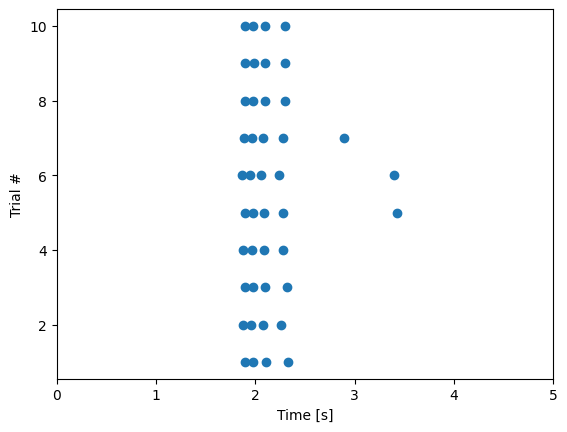

In [94]:
plt.scatter(df['Time'], df['Trial']+1)
plt.xlabel('Time [s]')
plt.ylabel('Trial #')
plt.xlim(0, 5)

## カーネル密度推定

では、カーネル密度推定によってイベントの発生頻度[Hz]を推定していきます。
カーネル密度推定では、イベントの発生頻度 $\lambda(t)$ ($t$は時間)を以下のように推定します。
$$
    \lambda(t) \simeq \sum_{i} \frac{1}{w} h\left( \frac{t-t_i}{w} \right) \tag{1}
$$
ここで、$t_1, t_2, t_3, \ldots$ はイベント発生時刻のデータであり、$\sum_{i} f(t_i)$ は全ての $i = 1, 2, 3, \ldots$ について $f(t_i)$ の値を足し合わせるという意味です。また、$k(t)$ はカーネル関数と呼ばれ、一般に以下のガウス関数が用いられます。
$$
    h(t) = \frac{1}{\sqrt{2\pi}}\exp\left(-\frac{t^2}{2}\right)
$$
つまり、与えられたデータに含まれるイベント発生時刻ごとにガウス関数のような山を置き、
それを足し合わせたものが発生頻度になる、というのがカーネル密度推定です。
そして、$w$ はバンド幅と呼ばれるパラメータで、山の横幅を表します。

では、式(1)を実装してみましょう。総和 $\sum$ を `for` 文で計算すれば、以下のように書けます。

In [95]:
def kernel(t):
    return np.exp(-t**2/2) / (np.sqrt(2*np.pi))

def kde(t,      # 時間
        ftime,  # イベント発生時刻のデータ
        w=0.1): # バンド幅
    v = 0
    for ti in ftime:
        v += (1/w) * kernel((t-ti)/w)
    return v

では、この `kde` 関数を使って、時間とともに変化するイベント発生頻度を計算します。
ここでは、ひとまず `w=0.1` としておきましょう。ここでは、`n_trial` 個の試行のデータをまとめて扱っているため、そのままでは発生頻度が `n_trial` 倍になってしまいます。そこで、 `n_trial` で割っていることに注意しましょう。

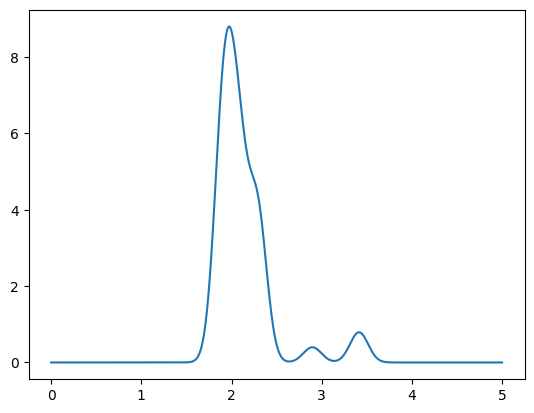

In [96]:
w = 0.1

time = np.linspace(0, 5, 5001) # 0.000, 0.001, 0.002, ..., 5.000
firing_rate = [kde(t, df['Time'], w=w) / n_trial for t in time]

plt.plot(time, firing_rate)

はい、このようにカーネル密度推定を使うことができます。

ここで、カーネル密度推定についてより具体的なイメージを持ってもらうために、以下のような図を作っておきましょう。ここでは、図の見やすさのために、1番目の試行のデータのみ用いることにします。この図から、カーネル密度推定は、緑色の線で示したカーネル関数の山々を足し合わせたものだということがよく分かります。

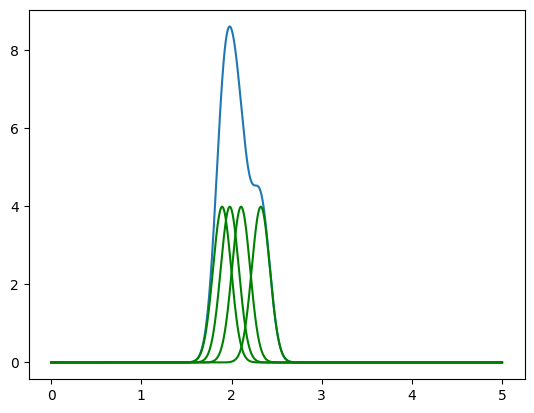

In [97]:
ftime = df['Time'][df['Trial'] == 0]
firing_rate = [kde(t, ftime, w=w) for t in time]
plt.plot(time, firing_rate)

for ti in ftime:
    plt.plot(time, (1/w)*kernel((time-ti)/w), 'g')


なお、ここでは理解を深めるために自分でカーネル密度推定を実装しましたが、`scipy.stats.gaussian_kde` などのライブラリを利用することもできます。上と同じことが、以下のようにコードを書くことで実現できます。

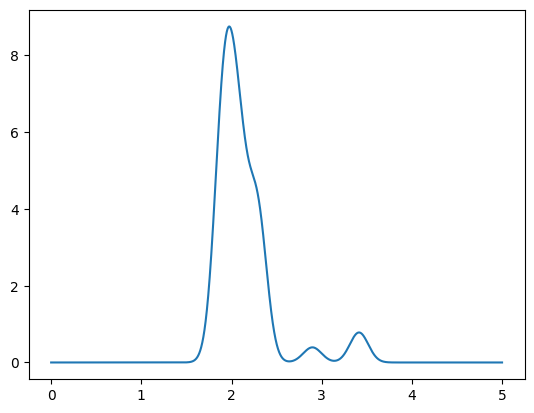

In [98]:
from scipy.stats import gaussian_kde

w = 0.1
factor = w / np.std(df['Time'])
kde2 = gaussian_kde(df['Time'], bw_method=factor)
firing_rate = kde2(time) * len(df['Time']) / n_trial

plt.plot(time, firing_rate)

## カーネルのバンド幅

次に、バンド幅 `w` の役割を説明します。
バンド幅 `w` はカーネル関数の山の横幅に相当するパラメータであり、
この値を大きくすると、カーネル関数の山が広がります。逆に、小さくすると山が狭くなります。
バンド幅 `w` が大きいと、カーネル密度推定の結果は滑らかになりますが、細かい構造が見えにくくなります。
逆に、バンド幅 `w` が小さいと、カーネル密度推定の結果は細かい構造が見えやすくなりますが、ノイズが大きくなります。

では、バンド幅を少し小さくして、`w=0.01` としてみましょう。以下のように、細かい構造が見やすくなりました。

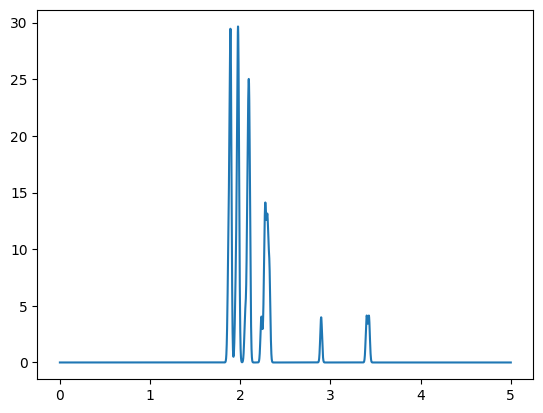

In [99]:
w = 0.01
firing_rate = [kde(t, df['Time'], w=w) / n_trial for t in time]

plt.plot(time, firing_rate)

では、さらに小さく、`w=0.001` としてみましょう。すると、以下のように、ノイズが大きくなってしまいました。
このようにバンド幅 `w` を変化させて推定結果をプロットすることで、適切に `w` を選ぶことの重要性が分かります。

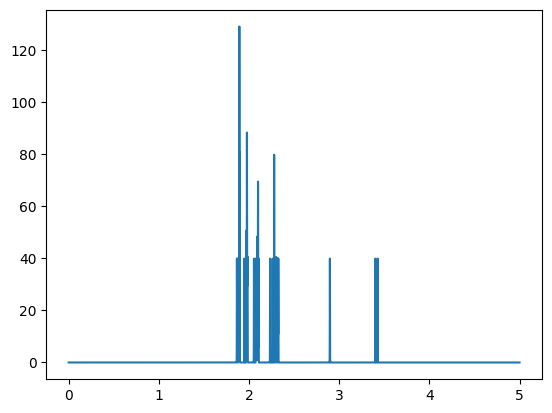

In [100]:
w = 0.001
firing_rate = [kde(t, df['Time'], w=w) / n_trial for t in time]

plt.plot(time, firing_rate)

## バンド幅の選び方

バンド幅を最適に決定する方法として、ここでは、Shimazaki & Shinomoto (2010)を紹介します。この方法はとてもシンプルで、以下の関数 $C(w)$ の値が最小となるようなバンド幅 $w$ を選ぶというものです(論文のAlgorithm 1)。
$$
    C(w) = \frac{1}{n^2} \sum_{i,j} \psi(t_i, t_j) - \frac{2}{n^2} \sum_{i \neq j} k(t_i - t_j)
$$
ここで、$n$ はイベントの合計発生回数、$t_1, t_2, \ldots, t_n$ はイベント発生時刻のデータです。
また、カーネル関数としてガウス関数を使う場合、関数 $\psi(t_i, t_j), k(t_i - t_j)$は以下のように書けます(論文の式(3), (24))。
$$
    \psi(t_i, t_j) = \frac{1}{2\sqrt{\pi}w} \exp\left( -\frac{(t_i-t_j)^2}{4w^2} \right)
$$
$$
    k(t_i - t_j) = \frac{1}{\sqrt{2\pi}w} \exp\left( -\frac{(t_i-t_j)^2}{2w^2} \right)
$$

論文: https://link.springer.com/article/10.1007/s10827-009-0180-4

この関数 $C(w)$ の計算は以下のように実装できます。

In [101]:
def k(ti, tj, w=0.1):
    return np.exp(-(ti - tj)**2/(2*w**2)) / (w*np.sqrt(2*np.pi))

def psi(ti, tj, w=0.1):
    return np.exp(-(ti - tj)**2/(4*w**2)) / (2*w*np.sqrt(np.pi))

def C(w,      # バンド幅
      ftime): # イベント発生時刻のデータ
    n = len(ftime)
    v = 0
    for i, ti in enumerate(ftime):
        for j, tj in enumerate(ftime):
            v += (1/n**2) * k(ti, tj, w=w)
            if i != j:
                v -= (2/n**2) * psi(ti, tj, w=w)
    return v

では、バンド幅 $w$ の値を変えながら繰り返し関数 $C(w)$ の値を計算し、
関数 $C(w)$ が最小となるバンド幅 $w$ を探します
(この場合、関数の極小点が1つとは限らないため、勾配法などの方法は得策ではありません)。
ここで、バンド幅 $w$ の値を指数的に変化させるのがポイントです。

optimal w: 0.008497534359086447


Text(0, 0.5, 'C(w)')

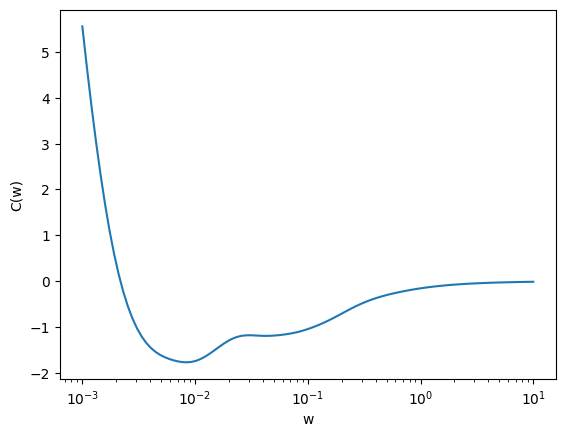

In [102]:
list_w = 10 ** np.linspace(-3, 1, 100)
list_C = [C(w, df['Time']) for w in list_w]

index = np.argmin(list_C)
print('optimal w:', list_w[index])

plt.plot(list_w, list_C)
plt.xscale('log')
plt.xlabel('w')
plt.ylabel('C(w)')

このように最適なバンド幅 $w^* \simeq 0.0085$ を得ることができました。
最後に、コードを整理して、最適なバンド幅を計算する関数 `potimal_w` を書いておきます。

In [103]:
def optimal_w(C, ftime, list_w=None):
    if list_w is None:
        list_w = 10 ** np.linspace(-3, 1, 100)
    list_C = [C(w, ftime) for w in list_w]
    index = np.argmin(list_C)
    return list_w[index]

w = optimal_w(C, df['Time'])

print('optimal w:', w)

optimal w: 0.008497534359086447


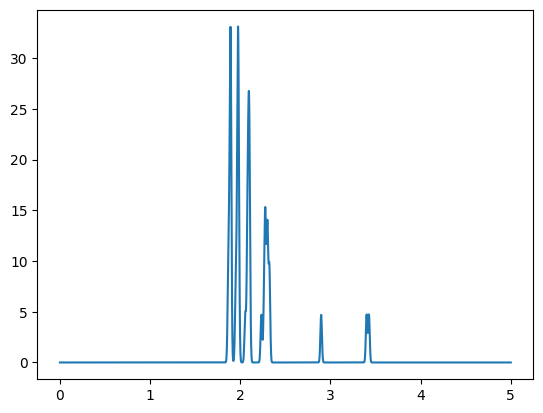

In [104]:
firing_rate = [kde(t, df['Time'], w=w) / n_trial for t in time]
plt.plot(time, firing_rate)

## バンド幅の選び方(発展編)

前節では、バンド幅$w$の値を1つに定めましたが、最適な$w$は時間とともに変化するという可能性もあります。
そこで、バンド幅$w$が時間とともに変化する、可変バンド幅$w(t)$を考えることもできます(論文のAlgorithm 2)。
ただ、皆さんには論文のAlgorithm 2を実装するのは難しいかもしれないので、
論文とは少し違いますが、次のように考えて実装してみるのがいいかもしれません。

まず、関数 `kde` を書き直して、カーネルの山一つずつ違うバンド幅$w$を与えられるようにします(引数 `w` はリストです)。

In [105]:
def kde(t, ftime, w=None):
    if w is None:
        w = 0.1 * np.ones_like(ftime)
    v = 0
    for i, ti in enumerate(ftime):
        v += np.exp(-(t - ti)**2/(2*w[i]**2)) / (w[i]*np.sqrt(2*np.pi))
    return v

次に、ある時刻 $t$ に最も近い10個のイベント発生時刻を抽出するコードを書きます。

In [106]:
t = df['Time'][0]
m = 10

index = np.argsort(np.abs(df['Time'] - t))
neighbors = df['Time'][index[:m]]

print(neighbors)

0     1.896
35    1.896
39    1.893
8     1.893
31    1.892
16    1.892
26    1.886
12    1.881
4     1.871
21    1.866
Name: Time, dtype: float64


この10個のデータだけを使ってバンド幅$w$を決定すると、以下のようになります。
同様に、イベントの発生時刻ごとにバンド幅$w$を決めていけば、可変バンド幅$w(t)$を実現できそうです。

In [108]:
w = optimal_w(C, neighbors)

print('optimal w:', w)

optimal w: 0.0036783797718286343
